# Training the model to predict a stock price increase in the next 10 days
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [65]:
import pandas as pd
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle

In [84]:
# Create the target variable

# pick a number of days divisble by 3 and add 10, since we will do a 66/33 test/train split
days_of_data = 310
data = yf.download(tickers='RXMD', period=f'{days_of_data}d', progress=False)

# Code the target variable 1 for a day if the price goes above
# that day's price * 1.05 (5% increase) any day in the next 10 days.
data['target'] = 0
for d in range(0, days_of_data - 10):
    close_day_zero = data.iloc[d][3]

    # look at the next 10 days
    for i in range (d+1, d+10):
        # get closing price on that day
        close_day_i = data.iloc[i][3]
        # if closing price on that day > closing price * 1.05 on initial day,
        # then set target = 1 for the initial day
        if close_day_i > close_day_zero * 1.05:
            data.iloc[d:d+1, 6] = 1
        
# truncate so we just have the first 90 rows, since we can't code the last 10
data = data.head(days_of_data - 10)

In [56]:
# check distribution of 0 vs. 1
data['target'].value_counts()

1    173
0    127
Name: target, dtype: int64

In [57]:
###############################################
# attach additional features to each row here #
###############################################

In [58]:
# 66/33 test/train split
train_days = int((days_of_data - 10) / 3 * 2)
test_days = int(train_days / 2)

x_train = data.head(train_days).drop(columns='target')
y_train = data['target'].head(train_days)

x_test = data.tail(test_days).drop(columns='target')
y_test = data['target'].tail(test_days)

In [59]:
# train the model
model = lgb.LGBMClassifier(learning_rate=0.01,max_depth=5,random_state=42)

model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.626025	valid_0's binary_logloss: 0.634168
[40]	training's binary_logloss: 0.580406	valid_0's binary_logloss: 0.604743
[60]	training's binary_logloss: 0.546813	valid_0's binary_logloss: 0.589005
[80]	training's binary_logloss: 0.517834	valid_0's binary_logloss: 0.581397
[100]	training's binary_logloss: 0.49299	valid_0's binary_logloss: 0.580282


LGBMClassifier(learning_rate=0.01, max_depth=5, random_state=42)

In [60]:
# evaluate model accuracy
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.8050
Testing accuracy 0.7200


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

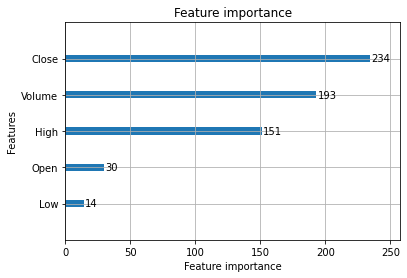

In [61]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

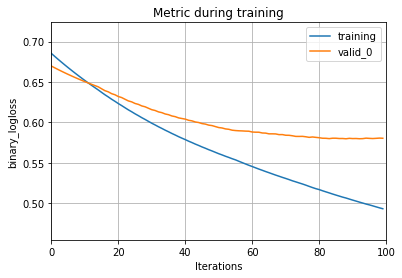

In [62]:
lgb.plot_metric(model)

/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


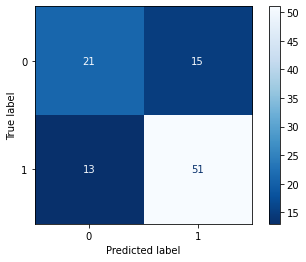

In [63]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [54]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        63
           1       0.00      0.00      0.00        37

    accuracy                           0.63       100
   macro avg       0.32      0.50      0.39       100
weighted avg       0.40      0.63      0.49       100



/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidfreitag/dfinance_proj/dfinance_proj_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [75]:
pkl_filename = 'lgbm_rxmd_model.pkl'

with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

In [76]:
print(x_test.tail(1))

            Open   High    Low  Close  Adj Close   Volume
Date                                                     
2022-01-06  0.03  0.032  0.028   0.03       0.03  2879300


In [77]:
# load the model
with open(pkl_filename, 'rb') as file:  
    model = pickle.load(file)

In [87]:
model.predict(x_test.tail(1))[0]

1